In [1]:
import os
import datetime


import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [10]:
TyneSpilmersford = getTimeSeriesForcasting("gauging-flow", "20003")
TyneSpilmersforddf= pd.DataFrame(data=TyneSpilmersford)

TyneSpilmersforddf

,Year Month,Value
0,1975-01-27T00:00:00,22.376
1,1975-09-12T00:00:00,13.504
2,1975-09-12T01:00:00,14.063
3,1975-09-18T00:00:00,29.077
4,1975-09-18T11:42:00,31.244
...,...,...
158,2019-06-13T09:15:00,25.178
159,2019-06-13T09:45:00,24.964
160,2019-06-13T13:30:00,21.922
161,2019-06-14T10:30:00,5.438


In [20]:
#data for timeseries model
from nrfaApi import *

TyneSpilmersford1 = getTimeSeriesForcasting("gdf", "20003")
TyneSpilmersforddf1= pd.DataFrame(data=TyneSpilmersford1)

TyneSpilmersforddf1

,Year Month,Value
0,1965-01-01,1.311
1,1965-01-02,1.019
2,1965-01-03,0.787
3,1965-01-04,0.691
4,1965-01-05,0.807
...,...,...
18467,2015-09-26,0.305
18468,2015-09-27,0.298
18469,2015-09-28,0.297
18470,2015-09-29,0.286


In [3]:
date_time = pd.to_datetime(TyneSpilmersforddf1.pop('Year Month'), format='%Y.%m.%d %H:%M:%S')
date_time

0       1965-01-01
1       1965-01-02
2       1965-01-03
3       1965-01-04
4       1965-01-05
           ...    
18467   2015-09-26
18468   2015-09-27
18469   2015-09-28
18470   2015-09-29
18471   2015-09-30
Name: Year Month, Length: 18472, dtype: datetime64[ns]

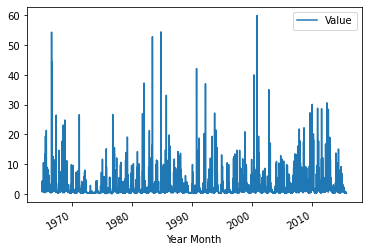

In [4]:
plot_cols = ['Value']
plot_features = TyneSpilmersforddf1[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)



In [5]:
df = TyneSpilmersforddf1.describe().transpose()
df

,count,mean,std,min,25%,50%,75%,max
Value,18472.0,1.483937,2.325304,0.141,0.475,0.8495,1.555,59.98


Text(0, 0.5, 'Gauged Daily Flow m3s-1')

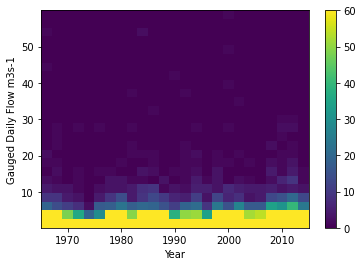

In [6]:
from nrfaApi import *
import matplotlib.pyplot as plt
#initial data anaylsis
hist = getTimeSeries("gdf", "20003")
histdf= pd.DataFrame(data=hist)
histdf
#plot of initial data anaylsis
plt.hist2d(histdf['Year'], histdf['Value'], bins=(25, 25), vmax=60)
plt.colorbar()
plt.xlabel('Year')
plt.ylabel('Gauged Daily Flow m3s-1')

In [ ]:
TyneSpilmersforddf1.pop('Year Month')
TyneSpilmersforddf1

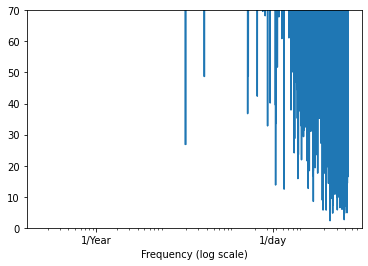

In [23]:
fft = tf.signal.rfft(TyneSpilmersforddf1['Value'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(TyneSpilmersforddf1['Value'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 70)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

In [24]:
df = TyneSpilmersforddf1

column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

In [25]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

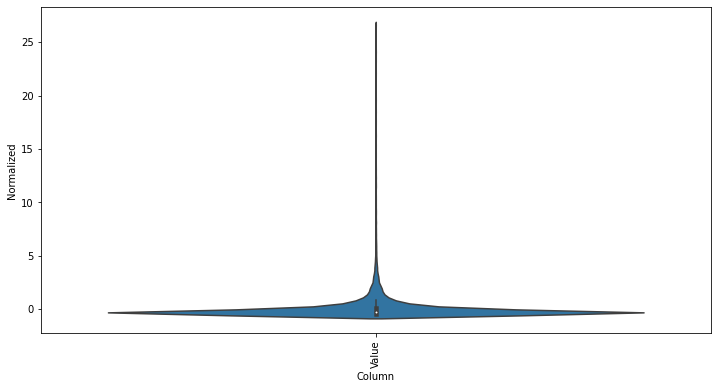

In [26]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

In [27]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [28]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=['Value'])
w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['Value']

In [29]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['Value'])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['Value']

In [30]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [31]:
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 1)
Inputs shape: (3, 6, 1)
Labels shape: (3, 1, 1)


In [32]:
w2.example = example_inputs, example_labels

In [35]:
def plot(self, model=None, plot_col='Value', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

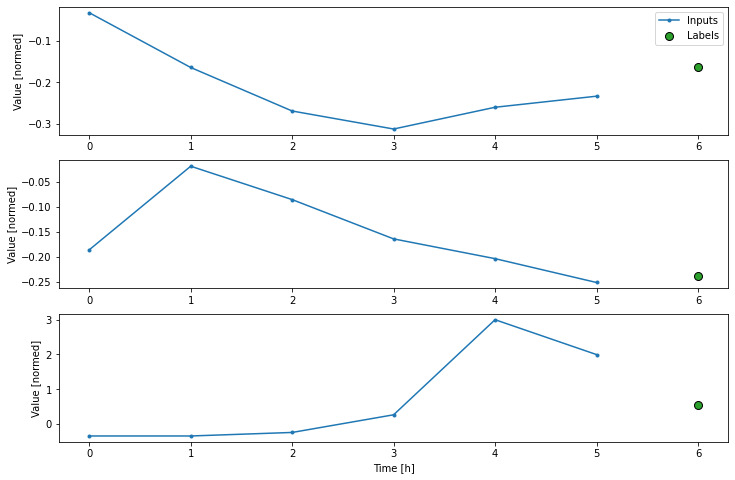

In [36]:
w2.plot()

In [ ]:
#section 4 to continue
#https://www.tensorflow.org/tutorials/structured_data/time_series